<a href="https://colab.research.google.com/github/Surajjoshi2004/Surajjoshi2004/blob/main/poweroutrageproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler


In [ ]:
#Loading our dataset
power_df = pd.read_csv("power_usage_2016_to_2020.csv")
weather_df = pd.read_csv("weather_2016_2020_daily.csv")

print(weather_df.head())


         Date  Day  Temp_max  Temp_avg  Temp_min  Dew_max  Dew_avg  Dew_min  \
0  2016-01-06    1        85      74.8        68       74     71.4       66   
1  2016-02-06    2        76      71.2        66       74     70.3       66   
2  2016-03-06    3        79      72.1        68       72     70.0       68   
3  2016-04-06    4        76      71.2        69       73     70.0       66   
4  2016-05-06    5        82      73.8        68       72     70.0       68   

   Hum_max  Hum_avg  Hum_min  Wind_max  Wind_avg  Wind_min  Press_max  \
0      100     89.4       65        21       9.5         0       29.8   
1      100     96.8       89        18       7.8         0       29.8   
2      100     93.6       72        18       4.7         0       29.8   
3      100     96.1       85        20       7.0         0       29.8   
4      100     88.7       62        17       7.7         0       29.7   

   Press_avg  Press_min  Precipit  day_of_week  
0       29.8       29.7      0.00    

In [ ]:

power_df["Date"] = pd.to_datetime(power_df["StartDate"])
weather_df["Date"] = pd.to_datetime(weather_df["Date"])

In [ ]:
merged_df = pd.merge(power_df, weather_df, on="Date", how="inner")
print(merged_df.head)

<bound method NDFrame.head of                 StartDate  Value (kWh)  day_of_week_x           notes  \
0     2016-01-06 00:00:00        1.057              2         weekday   
1     2016-02-06 00:00:00        1.281              5         weekend   
2     2016-03-06 00:00:00        0.736              6         weekend   
3     2016-04-06 00:00:00        0.636              2         weekday   
4     2016-05-06 00:00:00        1.033              4         weekday   
...                   ...          ...            ...             ...   
1493  2020-03-07 00:00:00        1.313              5  COVID_lockdown   
1494  2020-04-07 00:00:00        0.807              1  COVID_lockdown   
1495  2020-05-07 00:00:00        1.804              3  COVID_lockdown   
1496  2020-06-07 00:00:00        1.769              6  COVID_lockdown   
1497  2020-07-07 00:00:00        1.601              1         weekday   

           Date  Day  Temp_max  Temp_avg  Temp_min  Dew_max  ...  Hum_avg  \
0    2016-01-06 

In [ ]:
merged_df.ffill(inplace=True)

In [ ]:
merged_df["Hour"] = merged_df["Date"].dt.hour
merged_df["Day"] = merged_df["Date"].dt.day
merged_df["Month"] = merged_df["Date"].dt.month
merged_df["Year"] = merged_df["Date"].dt.year
merged_df["Weekday"] = merged_df["Date"].dt.weekday

In [ ]:
merged_df["Power_Lag_1"] = merged_df["Value (kWh)"].shift(1)
merged_df["Power_Lag_24"] = merged_df["Value (kWh)"].shift(24)
merged_df["Power_Lag_168"] = merged_df["Value (kWh)"].shift(168)  # 7 days

# Fill NaN values from shifting with previous values
merged_df.bfill(inplace=True)

In [ ]:
merged_df["Rolling_Mean"] = merged_df["Value (kWh)"].rolling(window=24, min_periods=1).mean()
merged_df["Outage"] = np.where(merged_df["Value (kWh)"] < 0.1 * merged_df["Rolling_Mean"], 1, 0)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Ensure correct feature names
features = ["Value (kWh)", "Temp_avg", "Hum_avg", "Wind_avg",
            "Power_Lag_1", "Power_Lag_24", "Power_Lag_168", "Hour", "Day", "Month", "Weekday"]

target = "Outage"

# Check if target column exists, otherwise create it
if target not in merged_df.columns:
    merged_df[target] = (merged_df["Value (kWh)"] < merged_df["Value (kWh)"].quantile(0.05)).astype(int)

# Handle missing values
merged_df.ffill(inplace=True)
merged_df.bfill(inplace=True)

# Select features and target variable
X = merged_df[features]
y = merged_df[target]

# Split data into train and test sets


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Train a Random Forest Classifier
model = RandomForestClassifier(n_estimators=200, random_state=42, max_depth=10)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       300

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



In [ ]:
print(weather_df.columns)


Index(['Date', 'Day', 'Temp_max', 'Temp_avg', 'Temp_min', 'Dew_max', 'Dew_avg',
       'Dew_min', 'Hum_max', 'Hum_avg', 'Hum_min', 'Wind_max', 'Wind_avg',
       'Wind_min', 'Press_max', 'Press_avg', 'Press_min', 'Precipit',
       'day_of_week'],
      dtype='object')


In [ ]:
y_train.value_counts()


,count
Outage,
0,1198


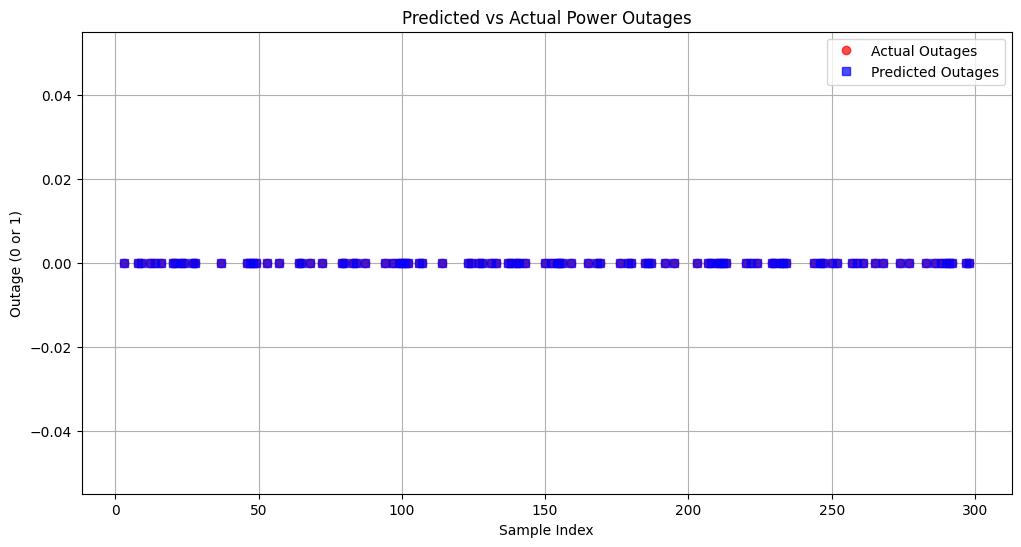

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Select a subset of data for better visualization
sample_size = 100  # Adjust based on data size
indices = np.random.choice(len(y_test), sample_size, replace=False)

plt.figure(figsize=(12, 6))
plt.plot(indices, y_test.iloc[indices], "ro", label="Actual Outages", alpha=0.7)  # Red dots for actual
plt.plot(indices, y_pred[indices], "bs", label="Predicted Outages", alpha=0.7)  # Blue squares for predicted

plt.xlabel("Sample Index")
plt.ylabel("Outage (0 or 1)")
plt.title("Predicted vs Actual Power Outages")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import numpy as np

print("Actual values distribution:")
print(np.unique(y_test, return_counts=True))

print("\nPredicted values distribution:")
print(np.unique(y_pred, return_counts=True))

Actual values distribution:
(array([0]), array([300]))

Predicted values distribution:
(array([0]), array([300]))
